#Plan of action
1. Import dependencies
2. Load in Files
3. Clean data
4. Explore Data
5. Convert gender column to numerical binary column
6. Standardize data 
7. Identify the best number of clusters
8. Build KMeans model
9. Create a column for cluster designation
10. Analyze cluster designation to key metrics (spending score and income)
11. Understand and describe customer segments. 

In [1]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [2]:
#load data
customer_df = pd.read_csv("/Users/Jerry/Documents/mall-customer-segmentation/Mall_Customers.csv")
customer_df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
#lets conduct our initial data exploration 
customer_df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


The average age among these customers is 39 years old with a range from the age of 18 to 70 years old. The average income is 61k with a standard deviation of 26 thousand. The range of income is a min of 15k and a max of 137k. Finally, the average spending score is 50 out of a range 1 to 100.

From this initial exploration, there is no apparent error among the ranges for each column. This data comes from a mall in Iowa with customers ranging from a wide variety of ages, incomes, and spending habits. 

### Cleaning Data

Let's clean the data before we explore the data further. I will check for null values, data types and any duplicate customer IDs. I will also change the name of two columns for simplicity.

In [4]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Thankfully, we have no null values in our dataset and our data types accurately represent the information in the correct form.

In [5]:
#removing duplicates
customer_df = customer_df.drop_duplicates()

In [6]:
#Renaming columns
customer_df = customer_df.rename(columns={"Annual Income (k$)": "Annual Income" , "Spending Score (1-100)": "Spending Score"})

### Data Exlporation

As discussed before, in this scenario we are working with the owner of a newly purchased mall. The owner has contacted us to help identify different groups among the customer demographic. Two important business metrics collected by the previous owner were estimated annual income and spending score for each customer. 

With this in mind we will take a look at the correlation between annual income and spending score to identify surface level/ initial groupings.

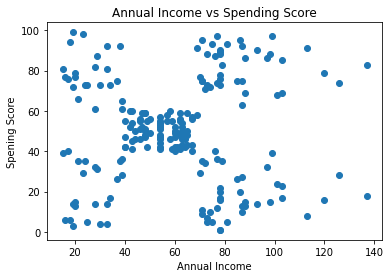

In [7]:
#Check correlation of spending score to income
plt.scatter(x=customer_df["Annual Income"], y=customer_df["Spending Score"])
plt.xlabel("Annual Income")
plt.ylabel("Spening Score")
plt.title("Annual Income vs Spending Score")
plt.show()

A few things we can take away from this scatter plot. We can distinctly indentify a condesed cluster in the middle of the graph, customers who spend on average the same amount they earn. On the left we have two moderatley condensed groups with low spending, one with low income and one with high income.  

At first glance we see 5 groups, but it could be 7 depending on how we consider the farest right points for high and low spenders. These points aren't far enough from the groups to confidently consider them their own groups, yet they aren't close enough to confidently place in them in the relatively closest group. We will need to do further analysis to identify the best number of groups.

Identifing the best number of clusters will help us avoid plots that look like a single cluster (too few clusters) or look like two clusters are competing for a single densely packed space (too many clusters). 

In [8]:
#add a new column to put customers into a group based on spending
group_list = []
score = 0

for i in range(1,201):
    customer = customer_df.loc[(customer_df["CustomerID"] == i), :]
    score = customer["Spending Score"].values
    
    if score < 10:
        group_list.append("0-10")
    elif score < 20:
        group_list.append("10-20")
    elif score < 30:
        group_list.append("20-30")
    elif score < 40:
        group_list.append("30-40")
    elif score < 50:
        group_list.append("40-50")
    elif score < 60:
        group_list.append("50-60")
    elif score < 70:
        group_list.append("60-70")
    elif score < 80:
        group_list.append("70-80")
    elif score < 90:
        group_list.append("80-90")
    else:
        group_list.append("90-100")

customer_df["Spending Group"] = group_list

customer_df.head()

,CustomerID,Gender,Age,Annual Income,Spending Score,Spending Group
0,1,Male,19,15,39,30-40
1,2,Male,21,15,81,80-90
2,3,Female,20,16,6,0-10
3,4,Female,23,16,77,70-80
4,5,Female,31,17,40,40-50


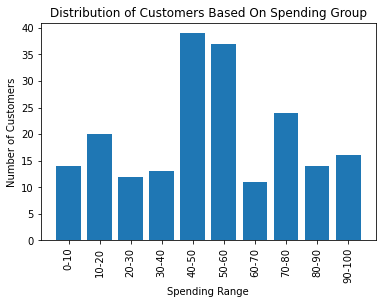

In [9]:
#The distribution of customers in spending group
count_list = customer_df.groupby(["Spending Group"])["CustomerID"].count()
label_list = count_list.index.tolist()
plt.bar(x=label_list, height=count_list)
plt.xticks(rotation= 90)
plt.xlabel("Spending Range")
plt.ylabel("Number of Customers")
plt.title("Distribution of Customers Based On Spending Group")
plt.show()


From this initial visualization we can conclude the majority of customers have a spending score ranging from 40 to 60. Other then this insight, there is no clear distinction of customer groupings here. We will need to do further analysis to find customer segments. 

In [10]:
#now lets visualize the distribution of spenders based on age
#customer_df.groupby(["Spending Group"])["Age"].describe()
grouped = customer_df.groupby(["Spending Group"]).mean()
grouped

,CustomerID,Age,Annual Income,Spending Score
Spending Group,,,,
0-10,94.428571,40.642857,55.928571,4.928571
10-20,124.800000,45.550000,71.650000,14.200000
20-30,133.833333,41.583333,76.083333,25.166667
30-40,85.615385,41.307692,53.000000,34.923077
40-50,86.897436,43.384615,55.230769,44.333333
50-60,84.027027,42.540541,54.513514,54.378378
60-70,96.272727,32.272727,59.000000,63.818182
70-80,98.250000,29.791667,58.416667,74.791667
80-90,126.857143,29.071429,72.285714,85.285714


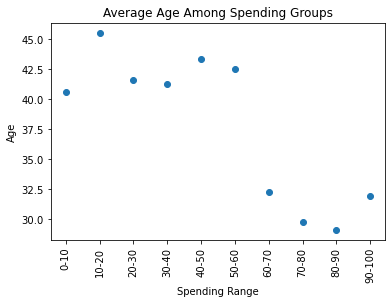

In [11]:
#Average Age Among Spening Groups
X = grouped.index.tolist()
Y = grouped["Age"].values

#plt.bar(x=X, height=Y)
plt.scatter(x=X, y=Y)
plt.xticks(rotation = 90)
plt.xlabel("Spending Range")
plt.ylabel("Age")
plt.title("Average Age Among Spending Groups")
plt.show()

We can see that on average younger customers are spending more at the mall. Intuitively, while we are young we tend to spend more and as we grow older we tend to be more methodical with our money.

5. Convert gender column to numerical binary column
6. Standardize data 
7. Identify the best number of clusters
8. Build KMeans model
9. Creating a column for cluster designation
10. Analyze cluster designation to key metrics (spending score and income)
11. Understand and describe customer segments. 

In [12]:
#convert gender column to binary column
customer_df["Gender"] = customer_df["Gender"].replace(to_replace={"Male": 0, "Female":1})

We will standardize data to ensure all variables hava a similar influence on cluster formation. We will assume the owner wants us to standardize all data since no instructions were given to leave a key metric out of standardization. This happens at times when a client wants a key metric to hold more influence on cluster formation. 

In [41]:
#standardize data
scaler = StandardScaler()

#use one of the two pairs of code
#filtered_data = customer_df[['Age', 'Annual Income', 'Spending Score', 'Gender']]
#scaled_data = scaler.fit_transform(filtered_data)

key_metrics = customer_df[['Annual Income', 'Spending Score']]
scaled_data = scaler.fit_transform(key_metrics)

In [42]:
#scaled_df = pd.DataFrame(data=scaled_data, columns=[['Age', 'Annual Income', 'Spending Score', 'Gender']])
scaled_df = pd.DataFrame(data=scaled_data, columns=[['Annual Income', 'Spending Score']])
scaled_df.head()

,Annual Income,Spending Score
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980


Since we are trying to cluster customers based on data collected we will use the KMeans model. This model is relatively simple, scales to larger data if needed, and generalizes to clusters of different shapes and sizes.

Before we can build a KMeans model, we will need to identify the best number for K using the elbow curve method. We won't be visually identifing K because it is to subjective and we won't use the silhouett score because it removes subjectivity from the judgment and is not a very intuitive metric. 

### Elbow Curve Technique

Insert explanation of elbow curve and what metric it uses. SSE also know as Inertia.

In [43]:
#Created a list called inertia to hold the inertia/SSE value for each iteration of the KMeans model.
inertia = []

#loop through each k to find the inertia for each iteration of the KMeans model
for k in range(1, 8):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled_data)
    inertia.append(model.inertia_)

#create dateframe to house inertia and k values
df = pd.DataFrame({"k": range(1,8), "inertia": inertia})
df

,k,inertia
0,1,400.000000
1,2,270.704267
2,3,157.704008
3,4,108.921317
4,5,65.568408
5,6,55.057348
6,7,44.911186


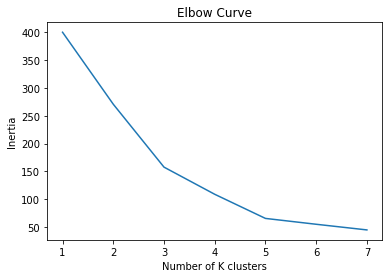

In [44]:
#Elbow Curve, we will plot the inertia value with the corresponding number of k.
k = range(1,8)
plt.plot(k, inertia)
plt.xlabel("Number of K clusters")
plt.ylabel("Inertia")
plt.title("Elbow Curve")
plt.show()

Now that we have identified the optimial number of clusters, we will create a function that builds a KMeans model using our input of k and data. The function will return the data with a new column containing the clusters found.

In [45]:
def get_clusters(k, data):
    #build and train the model
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(data)
    #predict the cluster
    predictions = km.predict(data)
    #create a column in the dataframe with the clusters found
    data["class"] = km.labels_

    return data

In [46]:
new_df = get_clusters(5, scaled_df)
new_df.head()

,Annual Income,Spending Score,class
0,-1.738999,-0.434801,4
1,-1.738999,1.195704,3
2,-1.700830,-1.715913,4
3,-1.700830,1.040418,3
4,-1.662660,-0.395980,4


In [47]:
#We will create a function that plots the clusters. 
def plot_clusters(df):
    plt.scatter(df["Spending Score"], df["Annual Income"], c=df["class"])
    plt.title("Customer Segments")
    plt.xlabel("Spending Score")
    plt.ylabel("Annual Income")
    plt.show()

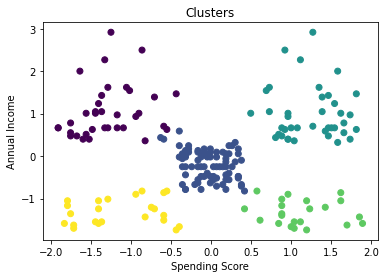

In [48]:
plot_clusters(new_df)

The graph above shows 5 segments which we calculated above as the optimal number of clusters. The color of a data point was determined by the cluster assigned to them through the KMeans algorithm. The clusters are almost completely distinct from one another. However the central cluster and the upper left cluster have a few points close to each other. 

### Exploring the new clusters

In [49]:
#we will include the class column to the original clean dataframe
customer_df["class"] = new_df["class"]

In [52]:
#we will group the customers by there cluster grouping and anlyze the mean of income and spend score
grouped_df = customer_df.groupby(["class"]).mean()

In [54]:
grouped_df.head()

,CustomerID,Gender,Age,Annual Income,Spending Score
class,,,,,
0,164.371429,0.457143,41.114286,88.200000,17.114286
1,86.320988,0.592593,42.716049,55.296296,49.518519
2,162.000000,0.538462,32.692308,86.538462,82.128205
3,23.090909,0.590909,25.272727,25.727273,79.363636
4,23.000000,0.608696,45.217391,26.304348,20.913043


In [74]:
income_means = round(grouped_df["Annual Income"], 2).to_list()
income_means

[88.2, 55.3, 86.54, 25.73, 26.3]

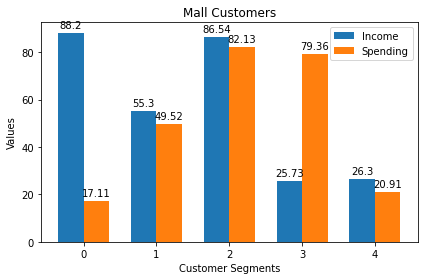

In [75]:
labels = grouped_df.index.to_list()
income_means = round(grouped_df["Annual Income"], 2).to_list()
spending_means = round(grouped_df["Spending Score"], 2).to_list()

#label locations
x = np.arange(len(labels))
#the width of the bars
width = .35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, income_means, width, label='Income')
rects2 = ax.bar(x + width/2, spending_means, width, label='Spending')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values')
ax.set_xlabel('Customer Segments')
ax.set_title('Mall Customers')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Mall Customer Segments:

0. Penny Pinchers
1. Average Joes
2. High Rollers
3. Over Spenders
4. Old Average Joes

Our Penny Pinchers, are people who make a lot, but spend a friction of their income. They tend to be older in established careers with their age averaging around their fourties.

Our average joes are around their fourties. They earn the average income and spend a little less then what they make. They live within their means, but also will indulge in their interests occasionally. 

Our high rollers make a lot, but spend almost as much as they make. Their age is around early thirites. They love to indulge in their interests. 

Our over spenders are typically in their twenties. They don't make much, but spend a lot. They don't live within their means, but aspire to one day make enough to afford their lifestyle. 

Lastly our old average joes, these customers are a lot older and make less then the average person. Nevertheless they still live within their means by spending less then they make. 

### Conclusion
We helped the mall gain a better understanding of its customers to enable better targeting and boost sales by identifying the optimial number of groups and by segmenting customers based on income and spending score. We hope these segments make all the difference and help maximize the ROI of the maketing campaign budget. 